Problem Statement

I decided to treat this as a classification problem by creating a new binary variable affair (did the woman have at least one affair?) and trying to predict the classification for each woman.

Dataset
The dataset I chose is the affairs dataset that comes with Statsmodels. 
It was derived from a survey of women in 1974 by Redbook magazine, in
which married women were asked about their participation in extramarital
affairs. More information about the study is available in a 1978 paper from
the Journal of Political Economy.

Description of Variables
The dataset contains 6366 observations of 9 variables:
rate_marriage: woman's rating of her marriage (1 = very poor, 5 = very good)
age: woman's age
yrs_married: number of years married
children: number of children
religious: woman's rating of how religious she is (1 = not religious, 4 = strongly religious)
educ: level of education (9 = grade school, 12 = high school, 14 =some college, 16 = college graduate, 17 = some graduate school, 20 = advanced degree)
occupation: woman's occupation (1 = student, 2 = farming/semi- skilled/unskilled, 3 = "white collar", 4 =
teacher/nurse/writer/technician/skilled, 5 = managerial/business, 6 = professional with advanced degree)
occupation_husb: husband's occupation (same coding as above)
affairs: time spent in extra-marital affairs




In [45]:
#Importing modules#

from __future__ import unicode_literals
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from patsy import dmatrices
from sklearn.linear_model import LogisticRegression
#from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split
from sklearn import metrics
#from sklearn.cross_validation import cross_val_score
from sklearn.model_selection import cross_val_score

#loading the dataset#

dta = sm.datasets.fair.load_pandas().data

# Add 'affair' column: 1 rpresents having affair, 0 doesn't#

dta['affair'] = (dta.affairs > 0).astype(int)

In [46]:
dta.groupby('affair').mean()

,rate_marriage,age,yrs_married,children,religious,educ,occupation,occupation_husb,affairs
affair,,,,,,,,,
0,4.329701,28.390679,7.989335,1.238813,2.504521,14.322977,3.405286,3.833758,0.000000
1,3.647345,30.537019,11.152460,1.728933,2.261568,13.972236,3.463712,3.884559,2.187243


Observation:

On average, women who have affairs rate their marriages lower.

In [47]:
dta.groupby('rate_marriage').mean()

,age,yrs_married,children,religious,educ,occupation,occupation_husb,affairs,affair
rate_marriage,,,,,,,,,
1.0,33.823232,13.914141,2.308081,2.343434,13.848485,3.232323,3.838384,1.201671,0.747475
2.0,30.471264,10.727011,1.735632,2.330460,13.864943,3.327586,3.764368,1.615745,0.635057
3.0,30.008056,10.239174,1.638469,2.308157,14.001007,3.402820,3.798590,1.371281,0.550856
4.0,28.856601,8.816905,1.369536,2.400981,14.144514,3.420161,3.835861,0.674837,0.322926
5.0,28.574702,8.311662,1.252794,2.506334,14.399776,3.454918,3.892697,0.348174,0.181446


Observation :

An increase in age, yrs_married, and children appears to correlate with a declining marriage rating.

Data Visualization

<IPython.core.display.Javascript object>


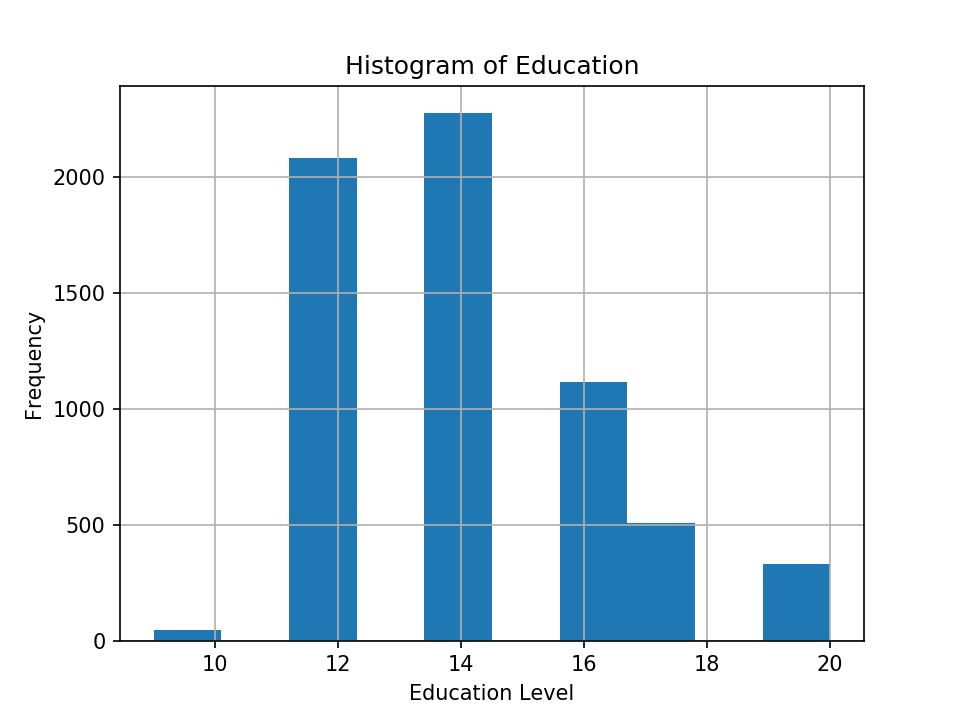

Text(0, 0.5, 'Frequency')

In [54]:
# histogram of education
dta.educ.hist()
plt.title('Histogram of Education')
plt.xlabel('Education Level')
plt.ylabel('Frequency')

<IPython.core.display.Javascript object>


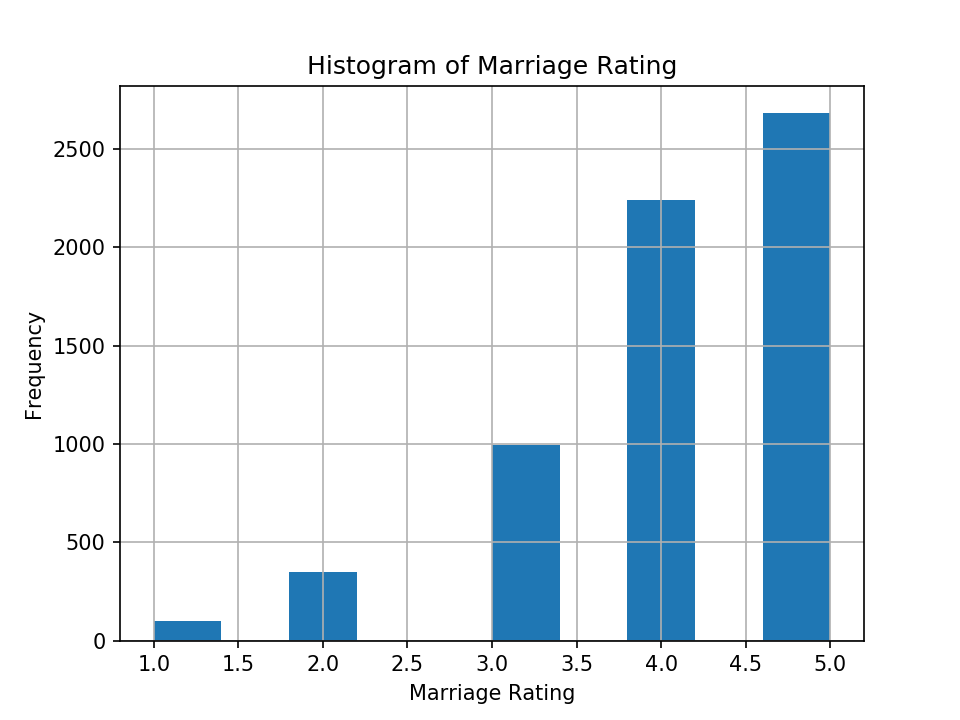

Text(0, 0.5, 'Frequency')

In [55]:
# histogram of marriage rating
dta.rate_marriage.hist()
plt.title('Histogram of Marriage Rating')
plt.xlabel('Marriage Rating')
plt.ylabel('Frequency')

Looking at the distribution of marriage ratings for those having affairs versus those not having affairs.

<IPython.core.display.Javascript object>


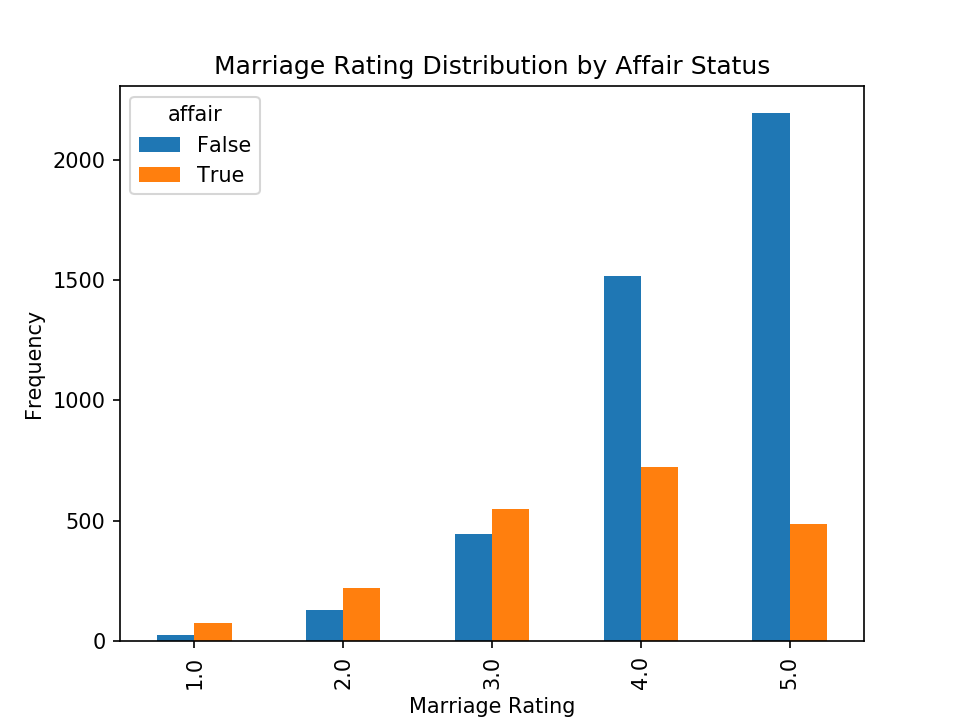

Text(0, 0.5, 'Frequency')

In [56]:
# barplot of marriage rating grouped by affair (True or False)
pd.crosstab(dta.rate_marriage, dta.affair.astype(bool)).plot(kind='bar')
plt.title('Marriage Rating Distribution by Affair Status')
plt.xlabel('Marriage Rating')
plt.ylabel('Frequency')

Using a stacked barplot to look at the percentage of women having affairs by number of years of marriage.

<IPython.core.display.Javascript object>


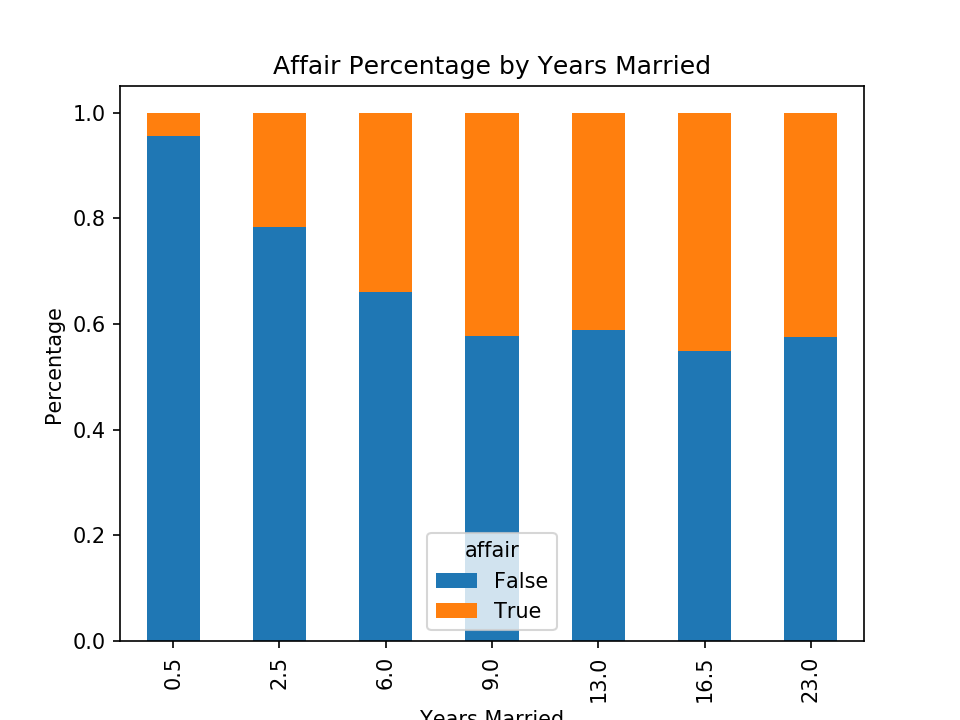

Text(0, 0.5, 'Percentage')

In [57]:
affair_yrs_married = pd.crosstab(dta.yrs_married, dta.affair.astype(bool))
affair_yrs_married.div(affair_yrs_married.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Affair Percentage by Years Married')
plt.xlabel('Years Married')
plt.ylabel('Percentage')

Prepare Data for Logistic Regression

To prepare the data, adding an intercept column as well as dummy variables for occupation and occupation_husb, since I'm treating them as categorial variables. The dmatrices function from the patsy module can do that using formula language.

In [58]:
dta.head()

,rate_marriage,age,yrs_married,children,religious,educ,occupation,occupation_husb,affairs,affair
0,3.0,32.0,9.0,3.0,3.0,17.0,2.0,5.0,0.111111,1
1,3.0,27.0,13.0,3.0,1.0,14.0,3.0,4.0,3.230769,1
2,4.0,22.0,2.5,0.0,1.0,16.0,3.0,5.0,1.400000,1
3,4.0,37.0,16.5,4.0,3.0,16.0,5.0,5.0,0.727273,1
4,5.0,27.0,9.0,1.0,1.0,14.0,3.0,4.0,4.666666,1


In [60]:
y, X = dmatrices('affair ~ rate_marriage + age + yrs_married + children + religious + educ + C(occupation) + C(occupation_husb)', dta, return_type="dataframe")
print(X.columns)

Index(['Intercept', 'C(occupation)[T.2.0]', 'C(occupation)[T.3.0]',
       'C(occupation)[T.4.0]', 'C(occupation)[T.5.0]', 'C(occupation)[T.6.0]',
       'C(occupation_husb)[T.2.0]', 'C(occupation_husb)[T.3.0]',
       'C(occupation_husb)[T.4.0]', 'C(occupation_husb)[T.5.0]',
       'C(occupation_husb)[T.6.0]', 'rate_marriage', 'age', 'yrs_married',
       'children', 'religious', 'educ'],
      dtype='object')


In [61]:
#Renaming the column names#

X = X.rename(columns = {'C(occupation)[T.2.0]':'occ_2',
                        'C(occupation)[T.3.0]':'occ_3',
                        'C(occupation)[T.4.0]':'occ_4',
                        'C(occupation)[T.5.0]':'occ_5',
                        'C(occupation)[T.6.0]':'occ_6',
                        'C(occupation_husb)[T.2.0]':'occ_husb_2',
                        'C(occupation_husb)[T.3.0]':'occ_husb_3',
                        'C(occupation_husb)[T.4.0]':'occ_husb_4',
                        'C(occupation_husb)[T.5.0]':'occ_husb_5',
                        'C(occupation_husb)[T.6.0]':'occ_husb_6'})

In [62]:
# flatten y into a 1-D array#
y = np.ravel(y)

Logistic Regression

In [72]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [75]:
# instantiate a logistic regression model, and fit with X and y
model = LogisticRegression(solver='lbfgs')
model = LogisticRegression()
model = model.fit(X, y)

# check the accuracy on the training set
model.score(X, y)

0.7258875274897895

73% accuracy seems good but what's the null error rate

In [76]:
# what percentage had affairs?
y.mean()

0.3224945020420987

Only 32% of the women had affairs, which means that you could obtain 68% accuracy by always predicting "no". 
So we're doing better than the null error rate, but not by much.

Let's examine the coefficients to see what we learn.

In [77]:
# examine the coefficients
pd.DataFrame(zip(X.columns, np.transpose(model.coef_)))

,0,1
0,Intercept,[1.489835891324933]
1,occ_2,[0.18806639024440983]
2,occ_3,[0.4989478668156914]
3,occ_4,[0.25066856498524825]
4,occ_5,[0.8390080648117001]
5,occ_6,[0.8339084337443315]
6,occ_husb_2,[0.1906359445867889]
7,occ_husb_3,[0.2978327129263421]
8,occ_husb_4,[0.1614088540760616]
9,occ_husb_5,[0.18777091388972483]


From the above output we can say-Increases in marriage rating and religiousness correspond to a 
decrease in the likelihood of having an affair. 

Model Evaluation

Splitting the data into training set and testing set

In [100]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
model=LogisticRegression()
model.fit=(X_train, y_train)

In [92]:
#predicting class labels for the test set#

predicted=model.predict(X_test)
print(predicted)

[1. 0. 0. ... 0. 0. 0.]


In [106]:
print(metrics.accuracy_score(y_test,predicted))


0.7324607329842932


The accuracy is 73%, which is the same as we experienced when training and predicting on the same data.

Model Evaluation Using Cross-Validation-

In [107]:
scores = cross_val_score(LogisticRegression(), X, y, scoring = 'accuracy', cv=10)
print(scores)
print(scores.mean())

[0.72100313 0.70219436 0.73824451 0.70597484 0.70597484 0.72955975
 0.7327044  0.70440252 0.75157233 0.75      ]
0.7241630685514876


It's still performing at 73% accuracy.So the model is ready for prediction!